In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input

In [2]:
# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# scale color
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [4]:
# vectorize
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
# autoencoder layers params 
input_size = np.prod(x_train.shape[1:]) # 784
hidden_size = 128
code_size = 32

In [6]:
noise_factors = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

In [7]:
models = []
losses = []
for noise_factor in noise_factors:
    x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
    x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)
    
    x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
    x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)
    
    # define model
    input_img = Input(shape=(input_size,))
    hidden_1 = Dense(hidden_size, activation='relu')(input_img)
    code = Dense(code_size, activation='relu')(hidden_1)
    hidden_2 = Dense(hidden_size, activation='relu')(code)
    output_img = Dense(input_size, activation='sigmoid')(hidden_2)
    
    autoencoder = Model(input_img, output_img)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    # fit model
    autoencoder.fit(x_train_noisy, x_train, epochs=10, verbose=0)
    # test and loss score
    loss = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)
    losses.append(loss)
    
    models.append(autoencoder)

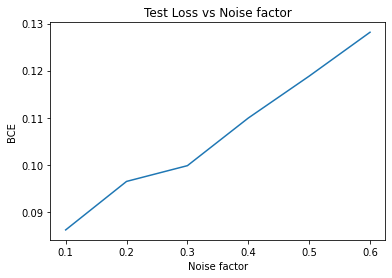

In [8]:
# plot loss score on test data for different noise factor
plt.plot(noise_factors,losses)
plt.xlabel('Noise factor')
plt.ylabel('BCE')
plt.title('Test Loss vs Noise factor')
plt.show()

In [9]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [10]:
# random n=10 images from x_test
n = 10
idx = np.random.choice(np.arange(x_test.shape[0]), size=n)
x_test_rnd = x_test[idx,:]

In [11]:
def plot_autoencoder_outputs(models, n, dims):
    avg_mse = []
    m = len(models)
    plt.figure(figsize=(10, 10))
    # plot original image
    for i in range(n):
        # plot original image
        ax = plt.subplot(m+1, n, i + 1)
        plt.imshow(x_test_rnd[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    for k in range(m):
        decoded_imgs = models[k].predict(x_test_rnd)
        mse_list = []
        for i in range(n):
            nposition = (k + 1)*n + i + 1
            ax = plt.subplot(m+1, n, nposition)
            plt.imshow(decoded_imgs[i].reshape(*dims))
            mse_diff = mse(x_test_rnd[i].reshape(*dims), decoded_imgs[i].reshape(*dims))
            mse_list.append(mse_diff)
            ax.set_title(f'{round(mse_diff,4)}')
            plt.gray()
            ax.get_xaxis().set_visible(False)
            if i==0:
                ax.get_yaxis().set_visible(True)
                ax.set_ylabel(f'{noise_factors[k]}')
            else:
                ax.get_yaxis().set_visible(False)
        avg_mse.append(sum(mse_list) / float(n))
    plt.show()
    return avg_mse

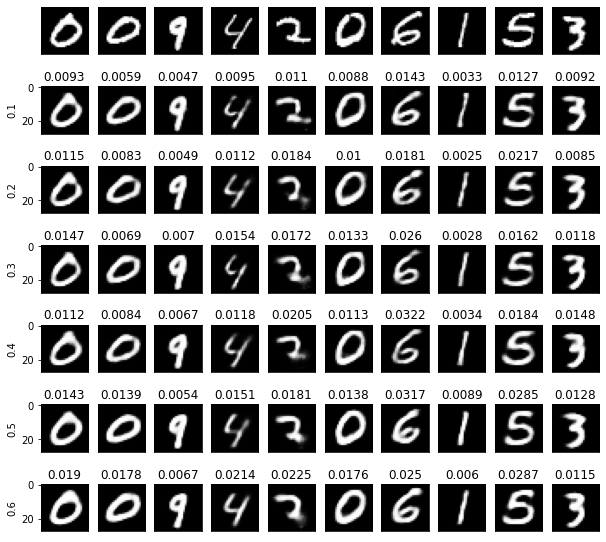

In [12]:
# First row - original images.
# Next row - noise factor and decoded images with diff MSE
avg_mse = plot_autoencoder_outputs(models, n, (28,28))

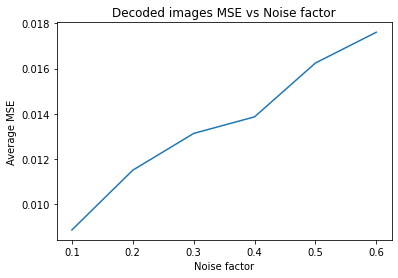

In [13]:
# plot average MSE between decoded and original images for range noise factors
plt.plot(noise_factors, avg_mse)
plt.xlabel('Noise factor')
plt.ylabel('Average MSE')
plt.title('Decoded images MSE vs Noise factor')
plt.show()